In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pathlib import Path
from linear2ac.io import get_main_data_folder
from skimage.exposure import rescale_intensity
import vr2p
import gcsfs, pickle
from matplotlib import pyplot as plt
from matplotlib import cm,colors,colormaps

# main parameters

In [17]:
animal = 'A7'
pix_size = [1.333,2] #xy

# load data.

In [4]:
# load data.
data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')

# registration data.
fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
with fs.open('gs://linear-2ac/registration_data/register.pkl', 'rb') as handle:
    deforms, trans_images,trans_masks, trans_label_im = pickle.load(handle)

# 1 Global displacement plots
## 1.0 General parameters

In [46]:
session = 8
img_type = 'mean_img' 
display_range = [250,1900]
fov_size_mm = 1.55
fov_origin_mm = [0.1,0.05] # left bottom origin.

# Calculate vectors and magnitude
x = deforms[session].get_field(0) * pix_size[0]
y = deforms[session].get_field(1) * pix_size[1]
magnitude = np.sqrt(np.power(x,2)+np.power(y,2))
# Get base image.
base_im = rescale_intensity(data.images.original[session][img_type],
                            in_range = tuple(display_range), out_range=(0,1)).astype(float)
extent=[0,(base_im.shape[1]*pix_size[0])/1000, 0,(base_im.shape[0]*pix_size[1])/1000]
# fov crop in x -y
fov_mm = [[fov_origin_mm[0],fov_origin_mm[0] + fov_size_mm],
          [fov_origin_mm[1],fov_origin_mm[1] + fov_size_mm]] 

##
# Helper functions
##

def array2rgb( array, disp_range,cmap):
    array = rescale_intensity(array,in_range = tuple(disp_range),out_range=(0,1)).astype(float)
    return cmap(array)

def add_weighted(im,weight):
    for i in range(3):
        im[:,:,i] *= weight
    return im

def plot_heatmap(im, d_range, colormap):
    heatmap_im = array2rgb( im, d_range,colormap)
    heatmap_im = add_weighted(heatmap_im,base_im)
    #plot
    fig = plt.figure(figsize=(2.5,2.5),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    # plot img.
    ax.imshow( heatmap_im, origin='lower',extent=extent, 
              interpolation='none', vmin=0, vmax=1) # correct non uniform aspect ratio.
    ax.axis('off')
    ax.set_xlim(fov_mm[0])
    ax.set_ylim(fov_mm[1])
    # set title
    title_str = f'fov size: {fov_size_mm} mm\n'
    title_str += f'{img_type} range: {display_range[0]}-{display_range[1]}\n'
    title_str += f'heatmap range: {d_range[0]}-{d_range[1]}'
    fig.suptitle(title_str,fontsize = 3)

# 1.1 FOV Overview

Text(0.5, 0.98, 'fov size: 1.55 mm\nmean_img range: 250-2350\n')

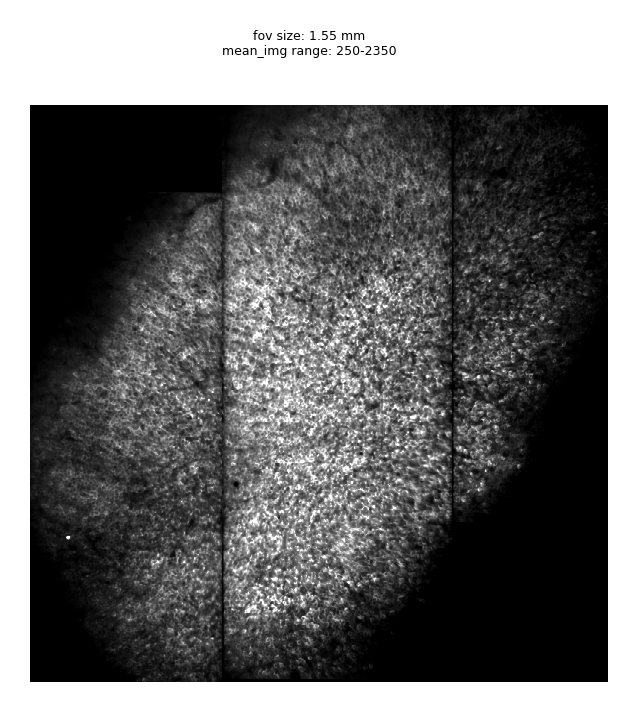

In [41]:
overview_disp_range = [250,2350]
overview_img_type = 'mean_img' 
fov_im = rescale_intensity(data.images.original[session][overview_img_type],
                            in_range = tuple(overview_disp_range), out_range=(0,1)).astype(float)
#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)

# plot img.
ax.imshow( fov_im, origin='lower',extent=extent, 
          interpolation='none',cmap='gray', vmin=0, vmax=1) # correct non uniform aspect ratio.
# format.
ax.axis('off')
ax.set_xlim(fov_mm[0])
ax.set_ylim(fov_mm[1])

# set title
title_str = f'fov size: {fov_size_mm} mm\n'
title_str += f'{overview_img_type} range: {overview_disp_range[0]}-{overview_disp_range[1]}\n'
fig.suptitle(title_str,fontsize = 3)

## 1.2 Magnitude

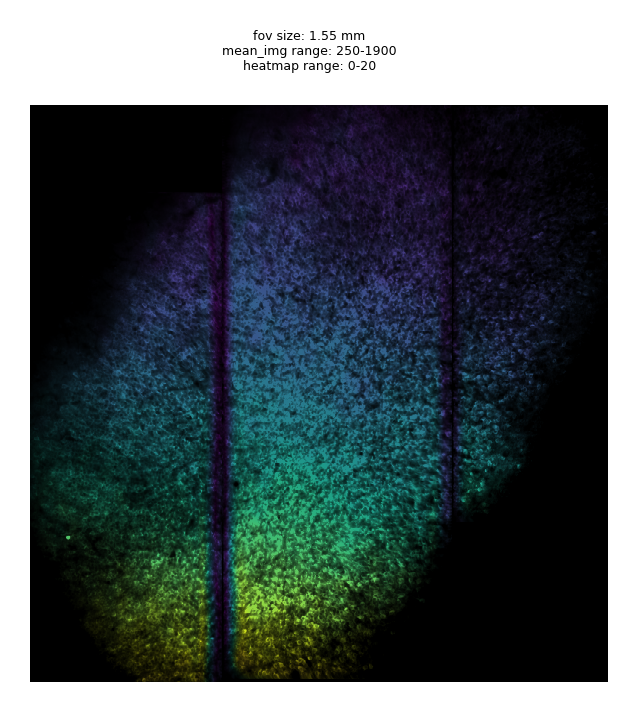

In [47]:
# Parameters
magnitude_range = [0,20]
magnitude_colormap_name = 'viridis'

#plot
plot_heatmap(magnitude, magnitude_range, colormaps[magnitude_colormap_name])

## 1.3 X Displacement

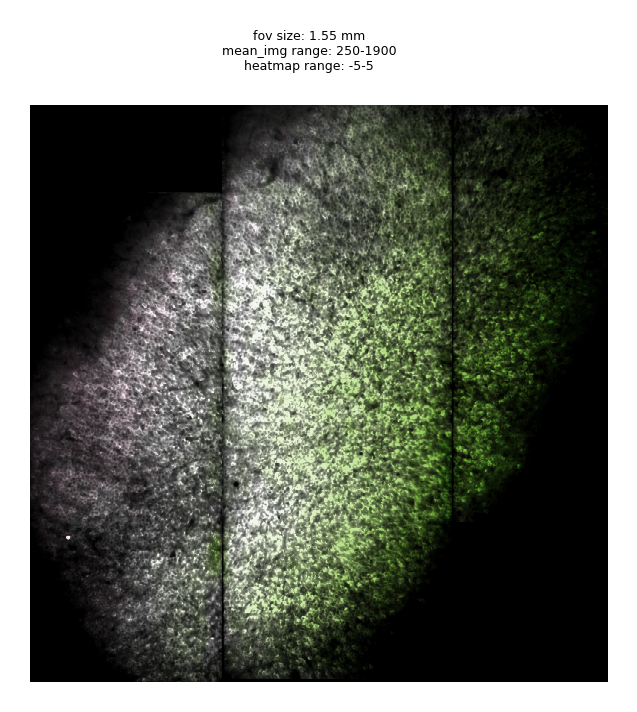

In [48]:
# Parameters
x_range = [-5,5]
x_colormap_name = 'PiYG'

#plot
plot_heatmap(x, x_range, colormaps[x_colormap_name])

## 1.4 Y Displacement

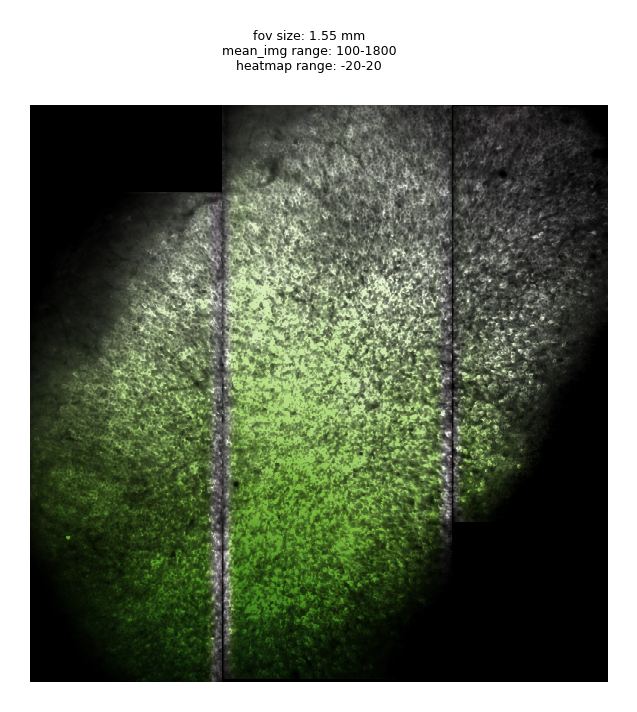

In [23]:
# Parameters
y_range = [-20,20]
y_colormap_name = 'PiYG'

#plot
plot_heatmap(y, y_range, colormaps[y_colormap_name])

# 2 Comparative displacement

In [50]:
def show_comparison_overlay(ax, im1, im2, crop_range, display_range, scale_size, scale_label):
    # color.
    im1 = array2rgb(im1, display_range,gencm((1,0,1)))
    im2 = array2rgb(im2, display_range,gencm((0,1,0)))
    ax.imshow(im1+im2, extent=[0,mm_im_size[0], 0,mm_im_size[1]],vmin = display_range[0],vmax = display_range[1])
    ax.set_axis_off()
    # crop.
    if crop_range:
        ax.set_xlim(crop_range[0], crop_range[1])
        ax.set_ylim(crop_range[2], crop_range[3]) 